# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [2]:
# levantamos los datos
df = pd.read_csv('podcast_dataset.csv')

# peek
df.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Healthy Living,Episode 77,99.25,Health,21.37,Thursday,Night,70.22,3,Positive,55.158695
1,Mystery Matters,Episode 6,19.43,True Crime,47.19,Friday,Evening,75.15,1,Neutral,7.686559
2,Current Affairs,Episode 1,117.03,News,96.33,Sunday,Night,57.95,3,Neutral,110.064645
3,Mystery Matters,Episode 38,16.97,True Crime,25.73,Monday,Night,24.19,0,Positive,12.000380
4,Humor Hub,Episode 73,83.48,Comedy,76.69,Tuesday,Afternoon,42.31,3,Positive,NaN


# Preprocessing

Ver notebook de EDA.

In [3]:
# drop duplicates
df.drop_duplicates(inplace=True)

# target relativo
df['fraction_listened'] = df['Listening_Time_minutes'] / df['Episode_Length_minutes']

# encoding de episode number
df['Episode_Number'] = df['Episode_Title'].apply(lambda x: x.split(" ")[-1]).astype(int)

# ausencia de guest
df['no_guest'] = df['Guest_Popularity_percentage'].isna()

# imputacion de NaNs
df.fillna({'Guest_Popularity_percentage':-1}, inplace=True)

# dropeo de NaNs de las otras columnas y reseteo de index
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

# encoding de sentiment
df['sentiment_encoded'] = df['Episode_Sentiment'].map({'Neutral':0, 'Negative':-1, 'Positive':1}).astype(int)

# drop de variables ahora redundantes
df.drop(columns=['Episode_Title', 'Episode_Sentiment'], inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40374 entries, 0 to 40373
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Podcast_Name                 40374 non-null  object 
 1   Episode_Length_minutes       40374 non-null  float64
 2   Genre                        40374 non-null  object 
 3   Host_Popularity_percentage   40374 non-null  float64
 4   Publication_Day              40374 non-null  object 
 5   Publication_Time             40374 non-null  object 
 6   Guest_Popularity_percentage  40374 non-null  float64
 7   Number_of_Ads                40374 non-null  int64  
 8   Listening_Time_minutes       40374 non-null  float64
 9   fraction_listened            40374 non-null  float64
 10  Episode_Number               40374 non-null  int64  
 11  no_guest                     40374 non-null  bool   
 12  sentiment_encoded            40374 non-null  int64  
dtypes: bool(1), floa

# Baseline

Para este problema elegimos minimizar el MSE/RMSE, aunque también miramos el MAE.

In [5]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
#from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from tqdm import tqdm

In [6]:
X = df.drop(columns=['Listening_Time_minutes','fraction_listened'])
y_abs = df['Listening_Time_minutes']
y_rel = df['fraction_listened']

In [7]:
numeric_cols = X.columns[X.dtypes!='object'].tolist()
numeric_cols

['Episode_Length_minutes',
 'Host_Popularity_percentage',
 'Guest_Popularity_percentage',
 'Number_of_Ads',
 'Episode_Number',
 'no_guest',
 'sentiment_encoded']

In [8]:
cat_cols = X.columns[X.dtypes=='object'].tolist()
cat_cols

['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time']

In [9]:
# utils
def rel_to_abs(y_pred_rel, X):
    return y_pred_rel * X['Episode_Length_minutes']

METRICS = {
    'mae': mean_absolute_error,
    'mse': mean_squared_error,
    'rmse': root_mean_squared_error,
}

SPLITTER = KFold(n_splits=5, random_state=42, shuffle=True)

def cv_model(model_constructor_f, X, is_rel, model_args={}):
    results = []
    models = []
    for i, (train_idx, test_idx) in tqdm(enumerate(SPLITTER.split(X)), 
                                         total=SPLITTER.get_n_splits()):
        X_train = X.loc[train_idx]
        X_test = X.loc[test_idx]

        y_train = y_rel[train_idx] if is_rel else y_abs[train_idx]
        y_test = y_abs[test_idx]

        # inst+fit model
        model = model_constructor_f(**model_args)

        model.fit(X_train, y_train)

        # predict
        y_pred = model.predict(X_test)

        # if rel, adjust to abs
        if is_rel:
            y_pred = rel_to_abs(y_pred, X_test)

        results.append({name:f(y_test, y_pred) for name,f in METRICS.items()})
        models.append(model)

    res_df = pd.DataFrame(results)
    # add mean and std values across folds for all metrics
    return pd.concat((res_df, res_df.describe().loc[['mean','std']])), models

In [10]:
# gráfico de importancias across-folds
# utils
def lr_weights(
        models: Pipeline | LinearRegression | list[Pipeline] | list[LinearRegression],
        feature_names: list[str],
        horizontal: bool = True,
        seed: int = 1234) -> None:
    if not isinstance(models, list):
        models = [models]
    if isinstance(models[0], Pipeline):
        models = [model[-1] for model in models]
    coefs = np.vstack([np.concatenate([*x.coef_, x.intercept_]) for x in models])
    df = pd.DataFrame(coefs, columns=feature_names+['intercept'])
    ax = sns.barplot(df, orient='h' if horizontal else 'v', seed=seed)
    ax.set_title(f"LR coefficients across evaluation procedure")
    plt.show()

def rf_importance(
        models: Pipeline | RandomForestRegressor | list[RandomForestRegressor] | list[Pipeline],
        feature_names: list[str],
        horizontal: bool = True,
        seed: int = 1234) -> None:
    if not isinstance(models, list):
        models = [models]
    if isinstance(models[0], Pipeline):
        models = [model[-1] for model in models]
    df_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=feature_names)
    ax = sns.barplot(df_importances, orient='h' if horizontal else 'v', seed=seed)
    ax.set_title(f"RF feature importances across evaluation procedure")
    plt.show()

## Sobre target absoluto

In [11]:
X_only_numeric = X[numeric_cols]
X_only_numeric

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Number,no_guest,sentiment_encoded
0,99.25,21.37,70.22,3,77,False,1
1,19.43,47.19,75.15,1,6,False,0
2,117.03,96.33,57.95,3,1,False,0
3,16.97,25.73,24.19,0,38,False,1
4,28.06,22.02,-1.00,1,87,True,0
...,...,...,...,...,...,...,...
40369,92.44,27.34,63.54,3,77,False,1
40370,50.30,20.61,55.63,0,100,False,1
40371,89.78,93.08,93.12,3,12,False,1
40372,77.86,41.04,52.33,2,18,False,1


In [12]:
res_rf_abs, models_rf_abs = cv_model(
    lambda **kwargs: RandomForestRegressor(**kwargs), 
    X=X_only_numeric,
    is_rel=False,
    model_args=dict(n_jobs=-1)
)

100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


In [13]:
res_rf_abs

,mae,mse,rmse
0,9.086769,134.672304,11.604840
1,8.944927,131.564962,11.470177
2,8.983914,132.972210,11.531358
3,8.996242,132.713907,11.520152
4,9.039005,133.341290,11.547350
mean,9.010171,133.052935,11.534775
std,0.054403,1.122611,0.048646


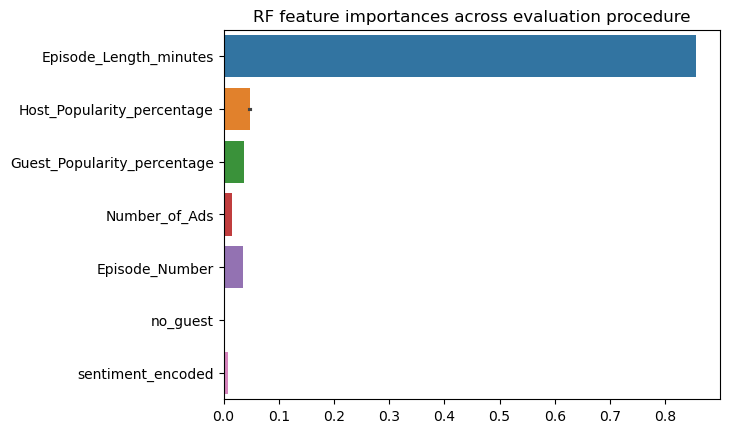

In [14]:
rf_importance(models_rf_abs, X_only_numeric.columns)

## Sobre target relativo

In [15]:
res_rf_rel, models_rf_rel = cv_model(
    lambda **kwargs: RandomForestRegressor(**kwargs), 
    X=X_only_numeric,
    is_rel=True,
    model_args=dict(n_jobs=-1)
)

100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


In [16]:
res_rf_rel

,mae,mse,rmse
0,9.061896,133.891293,11.571141
1,8.884489,130.020016,11.402632
2,8.955140,131.850715,11.482627
3,8.959701,131.947928,11.486859
4,9.053105,133.785367,11.566562
mean,8.982866,132.299064,11.501964
std,0.074436,1.601769,0.069691


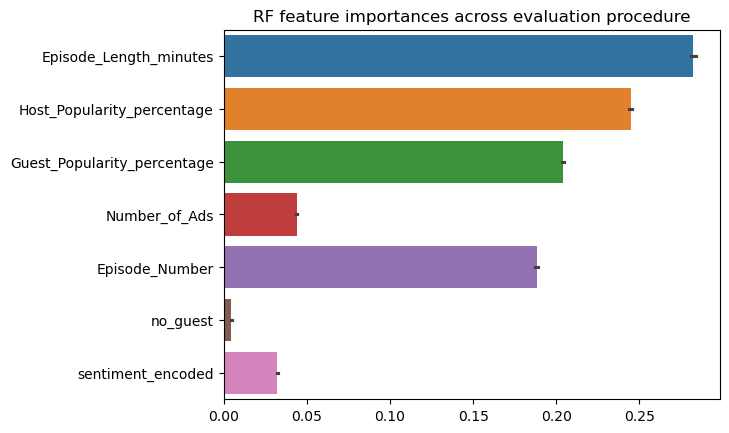

In [17]:
rf_importance(models_rf_rel, X_only_numeric.columns)

Se observa que la diferencia en performance entre usar target relativo y absoluto es mínima, aunque favorece levemente al target relativo.

Sin embargo, debe destacarse que el modelo con target relativo utiliza mucho mejor las diferentes features, mientras que el absoluto se concentra casi exclusivamente en la duración del podcast.

# Baseline + variables categóricas

## One Hot Encoding

In [18]:
res_onehot_rel, models_onehot_rel = cv_model(
    lambda : make_pipeline(
        make_column_transformer(
            ('passthrough',numeric_cols),
            (OneHotEncoder(sparse_output=False), cat_cols),
            sparse_threshold=0,
            n_jobs=-1
        ),
        RandomForestRegressor(n_jobs=-1)
    ),
    X=X,
    is_rel=True
)

100%|██████████| 5/5 [00:32<00:00,  6.50s/it]


In [19]:
res_onehot_rel

,mae,mse,rmse
0,9.015243,131.362369,11.461342
1,8.838851,127.284171,11.282029
2,8.866801,128.999646,11.357801
3,8.865036,127.714930,11.301103
4,8.906970,128.757438,11.347133
mean,8.898580,128.823711,11.349882
std,0.069612,1.587428,0.069780


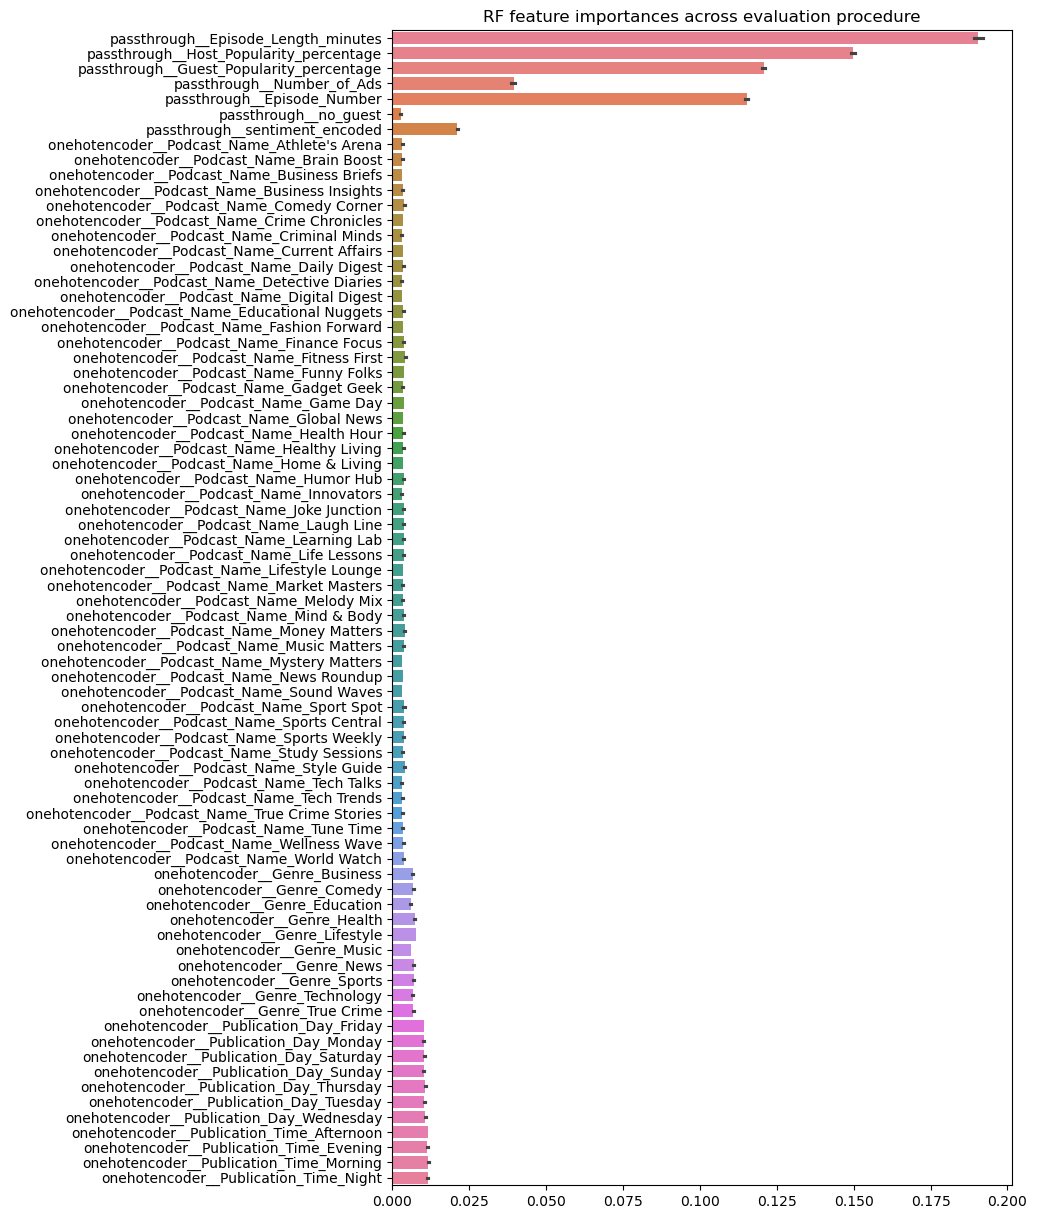

<Figure size 640x480 with 0 Axes>

In [20]:
fig, ax = plt.subplots(figsize=(8,15))
rf_importance(models_onehot_rel, models_onehot_rel[0][-2].get_feature_names_out())
plt.tight_layout()

## Target Encoding

In [21]:
res_tgt_rel, models_tgt_rel = cv_model(
    lambda : make_pipeline(
        make_column_transformer(
            ('passthrough',numeric_cols),
            (TargetEncoder(target_type='continuous', random_state=42), cat_cols),
            sparse_threshold=0,
            n_jobs=-1
        ),
        RandomForestRegressor(n_jobs=-1)
    ),
    X=X,
    is_rel=True
)

100%|██████████| 5/5 [00:19<00:00,  3.96s/it]


In [22]:
res_tgt_rel

,mae,mse,rmse
0,8.955120,130.183916,11.409817
1,8.850832,127.226502,11.279473
2,8.822978,127.587639,11.295470
3,8.840064,125.717678,11.212389
4,8.891537,127.855851,11.307336
mean,8.872106,127.714317,11.300897
std,0.052825,1.609311,0.071111


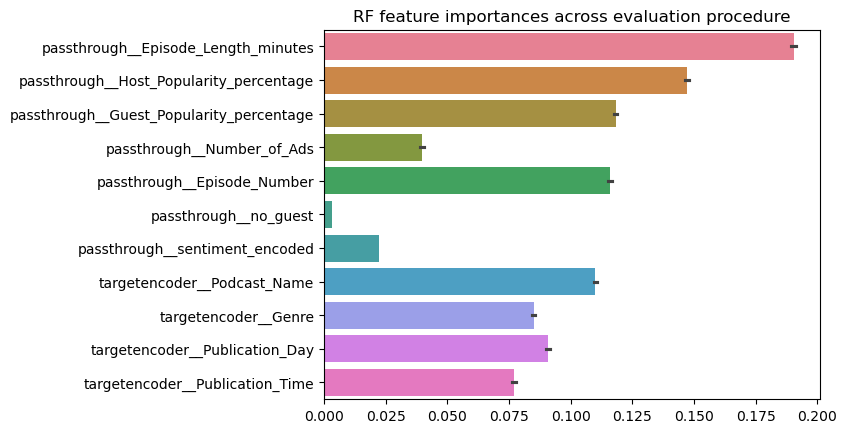

In [23]:
rf_importance(models_tgt_rel, models_tgt_rel[0][-2].get_feature_names_out())

Como se puede observar, la performance de las categorías encodeadas vía Target Encoding es superior a la de One Hot Encoding, incluso para aquellas de baja cardinalidad. Cabe destacar que el Target Encoder tiene hiperparámetros que no han sido tuneados, se están utilizando los default.

# Feature Engineering

In [24]:
# Comentado porque hay un error.

"""# cantidad media de ads por minuto 
X['ad_density'] = X['Number_of_Ads'] / X['Episode_Length_minutes']

# popularidad sumada de Host y Guest
X['joint_popularity'] = X['Host_Popularity_percentage'] + X['Guest_Popularity_percentage']

# como son pocas categóricas, se pueden hacer combinaciones y luego encodearlas por algún tipo de target encoding
for n in range(2,len(cat_cols)+1):
    for cols in combinations(cat_cols,n):
        cols_list = list(cols) # pandas gets angry if they're tuples instead of lists
        X[f"comb_{n}_"+"+".join(cols)] = X[cols_list].apply(lambda s: '-'.join(s), axis=1)"""

'# cantidad media de ads por minuto \nX[\'ad_density\'] = X[\'Number_of_Ads\'] / X[\'Episode_Length_minutes\']\n\n# popularidad sumada de Host y Guest\nX[\'joint_popularity\'] = X[\'Host_Popularity_percentage\'] + X[\'Guest_Popularity_percentage\']\n\n# como son pocas categóricas, se pueden hacer combinaciones y luego encodearlas por algún tipo de target encoding\nfor n in range(2,len(cat_cols)+1):\n    for cols in combinations(cat_cols,n):\n        cols_list = list(cols) # pandas gets angry if they\'re tuples instead of lists\n        X[f"comb_{n}_"+"+".join(cols)] = X[cols_list].apply(lambda s: \'-\'.join(s), axis=1)'

In [25]:
comb_cols = X.columns[X.columns.str.startswith('comb_')].tolist()

In [26]:
# a ver como se ve
X.head().T

,0,1,2,3,4
Podcast_Name,Healthy Living,Mystery Matters,Current Affairs,Mystery Matters,Money Matters
Episode_Length_minutes,99.25,19.43,117.03,16.97,28.06
Genre,Health,True Crime,News,True Crime,Business
Host_Popularity_percentage,21.37,47.19,96.33,25.73,22.02
Publication_Day,Thursday,Friday,Sunday,Monday,Wednesday
Publication_Time,Night,Evening,Night,Night,Morning
Guest_Popularity_percentage,70.22,75.15,57.95,24.19,-1.0
Number_of_Ads,3,1,3,0,1
Episode_Number,77,6,1,38,87
no_guest,False,False,False,False,True


Probamos su importancia utilizando un Random Forest con Target Encoding y valores default como antes.

In [27]:
res_fe_rel, models_fe_rel = cv_model(
    lambda : make_pipeline(
        make_column_transformer(
            ('passthrough',X.columns[X.dtypes != 'object']),
            (TargetEncoder(target_type='continuous', random_state=42), cat_cols+comb_cols),
            sparse_threshold=0,
            n_jobs=-1
        ),
        RandomForestRegressor(n_jobs=-1)
    ),
    X=X,
    is_rel=True
)

100%|██████████| 5/5 [00:15<00:00,  3.05s/it]


In [28]:
res_fe_rel

,mae,mse,rmse
0,8.988892,130.857814,11.439310
1,8.841536,127.333956,11.284235
2,8.831441,127.207911,11.278648
3,8.850235,125.837397,11.217727
4,8.916495,128.057652,11.316256
mean,8.885720,127.858946,11.307235
std,0.066613,1.858683,0.081980


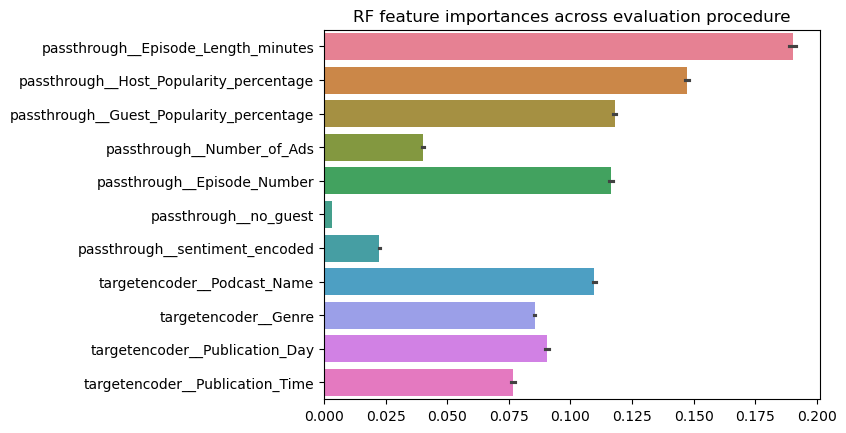

In [29]:
rf_importance(models_fe_rel, models_fe_rel[0][-2].get_feature_names_out())

Como se puede apreciar, con las nuevas variables el RMSE baja de 11.31 a 11.23 y el MAE de 8.88 a 8.83 (en media sobre 5 folds). Además la importancia de las variables es bastante alta y con poca variabilidad entre folds, lo que indica que tienen poder predictivo.

Por completitud se estima la performance utilizando target absoluto:

In [30]:
res_fe_abs, models_fe_abs = cv_model(
    lambda : make_pipeline(
        make_column_transformer(
            ('passthrough',X.columns[X.dtypes != 'object']),
            (TargetEncoder(target_type='continuous', random_state=42), cat_cols+comb_cols),
            sparse_threshold=0,
            n_jobs=-1
        ),
        RandomForestRegressor(n_jobs=-1)
    ),
    X=X,
    is_rel=False
)

res_fe_abs

100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


,mae,mse,rmse
0,8.984394,131.155370,11.452309
1,8.844483,127.506852,11.291893
2,8.873538,128.757734,11.347147
3,8.940591,129.384917,11.374749
4,8.945144,130.246757,11.412570
mean,8.917630,129.410326,11.375733
std,0.057088,1.395935,0.061376


Como era de esperarse, la performance es peor. Se confirma entonces qeu es mejor utilizar el target relativo.

# Testeo de diferentes modelos

**TO DO PROBAR DIFERENTES MODELOS CON VALORES DEFAULT**

* Ridge
* LASSO
* SVR
* LightGBM (probablemente el que mejor ande, probar usando su propio encoding en vez del Tgt Enc)

In [31]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

def make_preprocessed_pipeline(model, numeric_cols, cat_cols):
    preprocessor = make_column_transformer(
        ('passthrough', numeric_cols),
        (OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        remainder='drop',
        sparse_threshold=0,
    )
    
    return make_pipeline(preprocessor, StandardScaler(), model)

In [32]:
from sklearn.linear_model import Lasso, Ridge
res_lasso_rel, models_lasso_rel = cv_model(
    lambda: make_preprocessed_pipeline(Lasso(alpha=0.1), numeric_cols, cat_cols),
    X=X,
    is_rel=True
)

100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


In [33]:
res_lasso_rel

,mae,mse,rmse
0,9.209609,140.167239,11.839225
1,9.085107,136.077064,11.665207
2,9.125548,137.878952,11.742187
3,9.181672,137.886407,11.742504
4,9.198843,138.803393,11.781485
mean,9.160156,138.162611,11.754122
std,0.052998,1.494607,0.063589


In [34]:
res_ridge_rel, models_ridge_rel = cv_model(
    lambda: make_preprocessed_pipeline(Ridge(alpha=1.0), numeric_cols, cat_cols),
    X=X,
    is_rel=True
)

100%|██████████| 5/5 [00:01<00:00,  2.96it/s]


In [35]:
res_ridge_rel

,mae,mse,rmse
0,8.877918,126.952204,11.267307
1,8.752063,123.962696,11.133854
2,8.804853,125.246857,11.191374
3,8.796154,124.144580,11.142019
4,8.856516,125.605072,11.207367
mean,8.817501,125.182282,11.188384
std,0.050175,1.212411,0.054133


In [36]:
from sklearn.svm import SVR
# Comentado porque demora mucho tiempo (algunos minutos)
"""res_svr_rel, models_svr_rel = cv_model(
    lambda: make_preprocessed_pipeline(SVR(C=1.0, epsilon=0.1), numeric_cols, cat_cols),
    X=X,
    is_rel=True
)

res_svr_rel"""

'res_svr_rel, models_svr_rel = cv_model(\n    lambda: make_preprocessed_pipeline(SVR(C=1.0, epsilon=0.1), numeric_cols, cat_cols),\n    X=X,\n    is_rel=True\n)\n\nres_svr_rel'

In [37]:
# ejemplo de LightGBM
from lightgbm import LGBMRegressor

X_cats = X.copy()

for col in cat_cols+comb_cols:
    X_cats[col] = X_cats[col].astype("category")

X_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40374 entries, 0 to 40373
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Podcast_Name                 40374 non-null  category
 1   Episode_Length_minutes       40374 non-null  float64 
 2   Genre                        40374 non-null  category
 3   Host_Popularity_percentage   40374 non-null  float64 
 4   Publication_Day              40374 non-null  category
 5   Publication_Time             40374 non-null  category
 6   Guest_Popularity_percentage  40374 non-null  float64 
 7   Number_of_Ads                40374 non-null  int64   
 8   Episode_Number               40374 non-null  int64   
 9   no_guest                     40374 non-null  bool    
 10  sentiment_encoded            40374 non-null  int64   
dtypes: bool(1), category(4), float64(3), int64(3)
memory usage: 2.0 MB


In [38]:
res_lgb_rel, models_lgb_rel = cv_model(
    lambda : LGBMRegressor(num_leaves=31, max_bin=2048, subsample=1., subsample_freq=8, colsample_bytree=0.9),
    X=X_cats,
    is_rel=True
)

  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\javier\anaconda3\envs\myenv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\javier\anaconda3\envs\myenv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\javier\anaconda3\envs\myenv\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\javier\anaconda3\envs\myenv\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\javier\anaconda3\env

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6323
[LightGBM] [Info] Number of data points in the train set: 32299, number of used features: 11
[LightGBM] [Info] Start training from score 0.713479


 20%|██        | 1/5 [00:00<00:00,  4.42it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6322
[LightGBM] [Info] Number of data points in the train set: 32299, number of used features: 11
[LightGBM] [Info] Start training from score 0.713263


 60%|██████    | 3/5 [00:00<00:00,  4.71it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6321
[LightGBM] [Info] Number of data points in the train set: 32299, number of used features: 11
[LightGBM] [Info] Start training from score 0.712785


 80%|████████  | 4/5 [00:00<00:00,  4.72it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6323
[LightGBM] [Info] Number of data points in the train set: 32299, number of used features: 11
[LightGBM] [Info] Start training from score 0.713100


100%|██████████| 5/5 [00:01<00:00,  4.61it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6324
[LightGBM] [Info] Number of data points in the train set: 32300, number of used features: 11
[LightGBM] [Info] Start training from score 0.712298


100%|██████████| 5/5 [00:01<00:00,  4.63it/s]


In [39]:
res_lgb_rel

,mae,mse,rmse
0,8.875132,126.298831,11.238275
1,8.701733,122.375952,11.062366
2,8.737425,123.231458,11.100967
3,8.729361,122.194616,11.054167
4,8.807115,124.648173,11.164595
mean,8.770153,123.749806,11.124074
std,0.070362,1.723323,0.077318


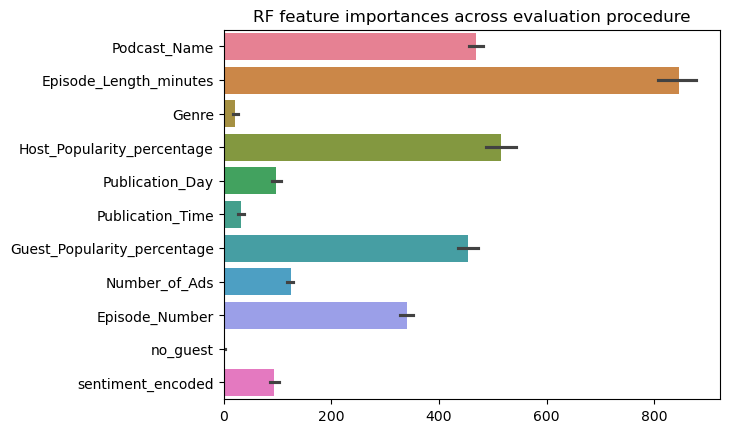

In [40]:
rf_importance(models_lgb_rel, X_cats.columns)

Parece que anda mal por insistencia en concentrarse en las mismas features, tal vez por eso anda mejor el RF? Ver los demás.


**TO DO HACER MINI FEATURE SELECTION Y HP TUNING SI ES POSIBLE CON OPTUNA Y W&B**

In [ ]:
import optuna

def objective_random_forest(trial):
    #n_estimators = trial.suggest_int('n_estimators', 50, 200)
    #max_depth = trial.suggest_int('max_depth', 2, 20)
    #min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

    n_estimators = trial.suggest_int('n_estimators', 50, 100) 
    max_depth = trial.suggest_int('max_depth', 3, 6)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
        n_jobs=-1
    )

    pipeline = make_preprocessed_pipeline(model, numeric_cols, cat_cols)

    score, _ = cv_model(
        lambda: pipeline,
        X=X,
        is_rel=True
    )

    return score['rmse'].mean()

# Descomentar para ejecutar la optimización sin W&B
#study = optuna.create_study(direction="minimize") 
#study.optimize(objective_random_forest, n_trials=10)

In [42]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: javiergonzaloetcheto (javiergonzaloetcheto-universidad-de-buenos-aires) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [43]:
from optuna.integration.wandb import WeightsAndBiasesCallback

wandb_kwargs = {
    "project": "optuna-rf", 
    "name": "random-forest-optimization" 
}
wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, as_multirun=True)

study = optuna.create_study(direction="minimize")
study.optimize(objective_random_forest, n_trials=10, callbacks=[wandbc])


C:\Users\javier\AppData\Local\Temp\ipykernel_15436\1237076300.py:7: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, as_multirun=True)
[I 2025-04-22 22:40:24,445] A new study created in memory with name: no-name-0c1ebcbd-2902-4cc1-9820-ca13599a1cda
100%|██████████| 5/5 [00:06<00:00,  1.21s/it]
[I 2025-04-22 22:40:30,491] Trial 0 finished with value: 9.509155536314319 and parameters: {'n_estimators': 96, 'max_depth': 6, 'min_samples_split': 4}. Best is trial 0 with value: 9.509155536314319.


max_depth,▁
min_samples_split,▁
n_estimators,▁
trial_number,▁
value,▁
max_depth,6
min_samples_split,4
n_estimators,96
trial_number,0
value,9.50916


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]
[I 2025-04-22 22:40:38,107] Trial 1 finished with value: 9.625712893506787 and parameters: {'n_estimators': 97, 'max_depth': 3, 'min_samples_split': 7}. Best is trial 0 with value: 9.509155536314319.


max_depth,▁
min_samples_split,▁
n_estimators,▁
trial_number,▁
value,▁
max_depth,3
min_samples_split,7
n_estimators,97
trial_number,1
value,9.62571


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]
[I 2025-04-22 22:40:44,814] Trial 2 finished with value: 9.521607707480394 and parameters: {'n_estimators': 58, 'max_depth': 5, 'min_samples_split': 9}. Best is trial 0 with value: 9.509155536314319.


max_depth,▁
min_samples_split,▁
n_estimators,▁
trial_number,▁
value,▁
max_depth,5
min_samples_split,9
n_estimators,58
trial_number,2
value,9.52161


100%|██████████| 5/5 [00:08<00:00,  1.63s/it]
[I 2025-04-22 22:40:56,321] Trial 3 finished with value: 9.509294566042117 and parameters: {'n_estimators': 93, 'max_depth': 6, 'min_samples_split': 3}. Best is trial 0 with value: 9.509155536314319.


max_depth,▁
min_samples_split,▁
n_estimators,▁
trial_number,▁
value,▁
max_depth,6
min_samples_split,3
n_estimators,93
trial_number,3
value,9.50929


100%|██████████| 5/5 [00:06<00:00,  1.24s/it]
[I 2025-04-22 22:41:05,771] Trial 4 finished with value: 9.626361882167485 and parameters: {'n_estimators': 77, 'max_depth': 3, 'min_samples_split': 10}. Best is trial 0 with value: 9.509155536314319.


max_depth,▁
min_samples_split,▁
n_estimators,▁
trial_number,▁
value,▁
max_depth,3
min_samples_split,10
n_estimators,77
trial_number,4
value,9.62636


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]
[I 2025-04-22 22:41:16,497] Trial 5 finished with value: 9.559169331913491 and parameters: {'n_estimators': 86, 'max_depth': 4, 'min_samples_split': 7}. Best is trial 0 with value: 9.509155536314319.


max_depth,▁
min_samples_split,▁
n_estimators,▁
trial_number,▁
value,▁
max_depth,4
min_samples_split,7
n_estimators,86
trial_number,5
value,9.55917


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
[I 2025-04-22 22:41:25,599] Trial 6 finished with value: 9.626666967811433 and parameters: {'n_estimators': 51, 'max_depth': 3, 'min_samples_split': 9}. Best is trial 0 with value: 9.509155536314319.


max_depth,▁
min_samples_split,▁
n_estimators,▁
trial_number,▁
value,▁
max_depth,3
min_samples_split,9
n_estimators,51
trial_number,6
value,9.62667


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]
[I 2025-04-22 22:41:33,614] Trial 7 finished with value: 9.625717387516998 and parameters: {'n_estimators': 98, 'max_depth': 3, 'min_samples_split': 9}. Best is trial 0 with value: 9.509155536314319.


max_depth,▁
min_samples_split,▁
n_estimators,▁
trial_number,▁
value,▁
max_depth,3
min_samples_split,9
n_estimators,98
trial_number,7
value,9.62572


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]
[I 2025-04-22 22:41:40,948] Trial 8 finished with value: 9.510128660938607 and parameters: {'n_estimators': 56, 'max_depth': 6, 'min_samples_split': 9}. Best is trial 0 with value: 9.509155536314319.


max_depth,▁
min_samples_split,▁
n_estimators,▁
trial_number,▁
value,▁
max_depth,6
min_samples_split,9
n_estimators,56
trial_number,8
value,9.51013


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]
[I 2025-04-22 22:41:47,049] Trial 9 finished with value: 9.626719434988487 and parameters: {'n_estimators': 60, 'max_depth': 3, 'min_samples_split': 4}. Best is trial 0 with value: 9.509155536314319.


max_depth,▁
min_samples_split,▁
n_estimators,▁
trial_number,▁
value,▁
max_depth,3
min_samples_split,4
n_estimators,60
trial_number,9
value,9.62672


In [44]:
print("Mejores parámetros:", study.best_params)
print("Mejor valor de la métrica (RMSE):", study.best_value)

Mejores parámetros: {'n_estimators': 96, 'max_depth': 6, 'min_samples_split': 4}
Mejor valor de la métrica (RMSE): 9.509155536314319


In [45]:
from sklearn.ensemble import GradientBoostingRegressor

def objective_gradient_boosting(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    n_estimators = trial.suggest_int('n_estimators', 50, 100)
    max_depth = trial.suggest_int('max_depth', 3, 6)

    model = GradientBoostingRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )

    pipeline = make_preprocessed_pipeline(model, numeric_cols, cat_cols)
    score, _ = cv_model(lambda: pipeline, X=X, is_rel=True)

    return score['rmse'].mean()


In [46]:
wandb_kwargs = {
    "project": "optuna-gbr", 
    "name": "gradient-boosting-optimization"
}

wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, as_multirun=True)

study = optuna.create_study(direction="minimize")
study.optimize(objective_gradient_boosting, n_trials=10, callbacks=[wandbc])

C:\Users\javier\AppData\Local\Temp\ipykernel_15436\636689585.py:6: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, as_multirun=True)
[I 2025-04-22 22:41:50,039] A new study created in memory with name: no-name-21c6e26f-245b-40c1-9e56-db18b99e850c
100%|██████████| 5/5 [00:25<00:00,  5.02s/it]
[I 2025-04-22 22:42:15,168] Trial 0 finished with value: 9.520680969710947 and parameters: {'learning_rate': 0.28167646854932815, 'n_estimators': 56, 'max_depth': 4}. Best is trial 0 with value: 9.520680969710947.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.28168
max_depth,4
n_estimators,56
trial_number,0
value,9.52068


100%|██████████| 5/5 [01:23<00:00, 16.71s/it]
[I 2025-04-22 22:43:42,127] Trial 1 finished with value: 9.64047147908032 and parameters: {'learning_rate': 0.2890525550150802, 'n_estimators': 76, 'max_depth': 6}. Best is trial 0 with value: 9.520680969710947.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.28905
max_depth,6
n_estimators,76
trial_number,1
value,9.64047


100%|██████████| 5/5 [00:56<00:00, 11.27s/it]
[I 2025-04-22 22:44:41,779] Trial 2 finished with value: 9.509759112752088 and parameters: {'learning_rate': 0.14020016625897364, 'n_estimators': 53, 'max_depth': 5}. Best is trial 2 with value: 9.509759112752088.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.1402
max_depth,5
n_estimators,53
trial_number,2
value,9.50976


100%|██████████| 5/5 [01:44<00:00, 20.90s/it]
[I 2025-04-22 22:46:29,279] Trial 3 finished with value: 9.503060215511114 and parameters: {'learning_rate': 0.05916029040105106, 'n_estimators': 87, 'max_depth': 6}. Best is trial 3 with value: 9.503060215511114.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.05916
max_depth,6
n_estimators,87
trial_number,3
value,9.50306


100%|██████████| 5/5 [00:40<00:00,  8.02s/it]
[I 2025-04-22 22:47:12,222] Trial 4 finished with value: 9.588130046010743 and parameters: {'learning_rate': 0.25428003640437413, 'n_estimators': 58, 'max_depth': 6}. Best is trial 3 with value: 9.503060215511114.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.25428
max_depth,6
n_estimators,58
trial_number,4
value,9.58813


100%|██████████| 5/5 [00:25<00:00,  5.09s/it]
[I 2025-04-22 22:47:40,740] Trial 5 finished with value: 9.507818669013107 and parameters: {'learning_rate': 0.2530830606950548, 'n_estimators': 68, 'max_depth': 3}. Best is trial 3 with value: 9.503060215511114.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.25308
max_depth,3
n_estimators,68
trial_number,5
value,9.50782


100%|██████████| 5/5 [00:18<00:00,  3.71s/it]
[I 2025-04-22 22:48:02,089] Trial 6 finished with value: 9.493807943160387 and parameters: {'learning_rate': 0.11822754755096751, 'n_estimators': 57, 'max_depth': 3}. Best is trial 6 with value: 9.493807943160387.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.11823
max_depth,3
n_estimators,57
trial_number,6
value,9.49381


100%|██████████| 5/5 [00:41<00:00,  8.40s/it]
[I 2025-04-22 22:48:46,972] Trial 7 finished with value: 9.50232255568378 and parameters: {'learning_rate': 0.03481022286790896, 'n_estimators': 84, 'max_depth': 5}. Best is trial 6 with value: 9.493807943160387.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.03481
max_depth,5
n_estimators,84
trial_number,7
value,9.50232


100%|██████████| 5/5 [00:30<00:00,  6.18s/it]
[I 2025-04-22 22:49:20,823] Trial 8 finished with value: 9.51526515885458 and parameters: {'learning_rate': 0.17697635768399483, 'n_estimators': 78, 'max_depth': 4}. Best is trial 6 with value: 9.493807943160387.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.17698
max_depth,4
n_estimators,78
trial_number,8
value,9.51527


100%|██████████| 5/5 [00:20<00:00,  4.09s/it]
[I 2025-04-22 22:49:44,487] Trial 9 finished with value: 9.496667144457819 and parameters: {'learning_rate': 0.1528115914632727, 'n_estimators': 66, 'max_depth': 3}. Best is trial 6 with value: 9.493807943160387.


learning_rate,▁
max_depth,▁
n_estimators,▁
trial_number,▁
value,▁
learning_rate,0.15281
max_depth,3
n_estimators,66
trial_number,9
value,9.49667


In [47]:
print("Mejores parámetros:", study.best_params)
print("Mejor valor de la métrica (RMSE):", study.best_value)

Mejores parámetros: {'learning_rate': 0.11822754755096751, 'n_estimators': 57, 'max_depth': 3}
Mejor valor de la métrica (RMSE): 9.493807943160387


Nota martín: lo que yo creo que habría que hacer:

* Probar diferentes modelos con valores default sobre todas las variables
* Alguno de esos va a andar notablemente mejor que los demás (seguramente LightGBM)
* Agarrar el que sea preferible y hacer backward selection probando de dropear `Number_of_Ads`, `no_guest` y `sentiment_encoded` a ver si la performance mejora (recordar que estamos midiendo RMSE)
* Ahí hacer HP tuning con optuna y w&b

Recordar que LightGBM usa su propio target encoder, ver [ref](https://lightgbm.readthedocs.io/en/stable/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor) e [integr con optuna](https://optuna-integration.readthedocs.io/en/stable/reference/index.html#lightgbm).
